In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import errno
from tqdm import tqdm
from torchvision import transforms
import shutil
import imgaug.augmenters as iaa
from PIL import Image
import random

### functions

In [13]:
def load_datasets(train_dir):
    """Loads and transforms the datasets."""
    # Resize the samples and transform them into tensors
    data_transforms = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])
    # Create a pytorch dataset from a directory of images
    train_dataset = datasets.ImageFolder(train_dir, data_transforms)
    return train_dataset

In [26]:
def splitting_data(original_path, out_train, out_val, proportion):
    """
    Split the data from the original_path directory according to the given proportion and the constraint of 1000 samples per class.
    :param proportion: the % of samples for the val
    """

    list_f = os.listdir(original_path)
    list_train = os.listdir(out_train)
    list_val = os.listdir(out_val)

    if '.DS_Store' in list_f:
        list_f.remove('.DS_Store')
    if '.DS_Store' in list_train:
        list_train.remove('.DS_Store')
    if '.DS_Store' in list_val:
        list_val.remove('.DS_Store')

    max_samples_per_class = 1000
    selected_indices = {}

    for class_ in tqdm(list_f):
        if class_ not in selected_indices:
            selected_indices[class_] = []

        for out_dir in [out_train, out_val]:
            try:
                os.makedirs(os.path.join(out_dir, class_))
            except OSError as e:
                if e.errno == errno.EEXIST:
                    os.system(f'rm -d -r {os.path.join(out_dir, class_)}')
                    os.makedirs(os.path.join(out_dir, class_))
                else:
                    raise e

        class_file_ = os.listdir(f'{original_path}/{class_}')
        # Get the number of pictures in the class
        n = max_samples_per_class
        # Calculate the number of pictures that are going to be moved to the val
        n_val = int(proportion * max_samples_per_class)
        # Calculate the number of pictures that are going to be moved to the train
        n_train = max_samples_per_class-n_val
        # Save the index for the val and train
        val_indices = np.random.choice(range(n), size=n_val, replace=False)
        train_indices = np.random.choice(range(n), size=n_train, replace=False)
        selected_indices[class_] += list(train_indices)  # Update selected indices for the class

        for i in train_indices:
            os.system(
                f'cp {os.path.join(original_path, class_, class_file_[i])} {os.path.join(out_train, class_, class_file_[i])}')
        for i in val_indices:
            os.system(
                f'cp {os.path.join(original_path, class_, class_file_[i])} {os.path.join(out_val, class_, class_file_[i])}')


In [3]:
j=0

In [4]:
# Augmentation function
def augment_image(image_path, output_path, num_augmented, seq,j):
    image = Image.open(image_path)

    # Convert image to RGB format
    image = image.convert("RGB")

    image = np.array(image)
    augmented_images = seq.augment_images([image] * num_augmented)
    for i, augmented_image in enumerate(augmented_images):
        augmented_image = Image.fromarray(augmented_image)
        augmented_image.save(os.path.join(output_path, f"augmented_{j}.png"))

In [5]:
def combine_dirs(directory1, directory2, output_directory):
    """
    Combine files from two directories that have the same subdirectory structure.
    :param directory1: Path to the first directory.
    :param directory2: Path to the second directory.
    :param output_directory: Path to the output directory.
    """
    for root, dirs, files in os.walk(directory1):
        relative_path = os.path.relpath(root, directory1)
        target_dir1 = os.path.join(directory1, relative_path)
        target_dir2 = os.path.join(directory2, relative_path)
        output_dir = os.path.join(output_directory, relative_path)

        # Create the corresponding output directory
        os.makedirs(output_dir, exist_ok=True)

        # Copy files from directory1 to the output directory
        for file in files:
            file1 = os.path.join(target_dir1, file)
            output_file = os.path.join(output_dir, file)
            shutil.copy(file1, output_file)

        # Copy files from directory2 to the output directory
        for file in os.listdir(target_dir2):
            file2 = os.path.join(target_dir2, file)
            output_file = os.path.join(output_dir, file)
            if os.path.isfile(file2) and not os.path.exists(output_file):
                shutil.copy(file2, output_file)

## Cleaning Data
In the first part, we will perform a data filtering in which we will remove unclear or incorrectly labeled examples
in order to prevent harm to the process of learning the model

after the cleaning process we will combine the train and val files.
##### class distributions:

In [15]:
base_dir = os.path.join('/Users/ofrihefetz/PycharmProjects/LAB2_2/augmentation_data')
all_data_1 = os.path.join(base_dir, "all_data_1")
clean_train_dataset = load_datasets(all_data_1)

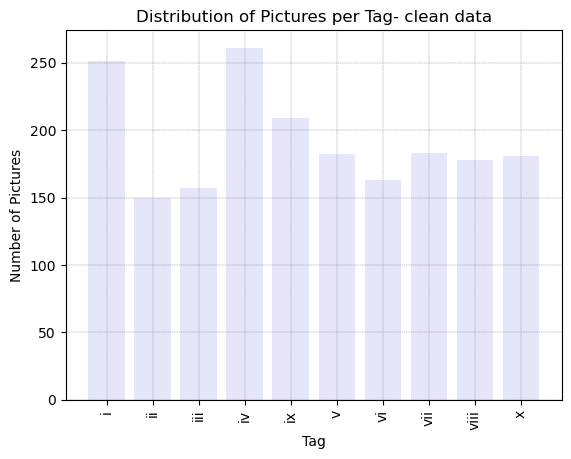

In [10]:
# Get the list of classes/tags in the dataset
class_names = clean_train_dataset.classes
# Count the number of pictures under each tag
tag_counts = [0] * len(class_names)
for _, label in clean_train_dataset:
    tag_counts[label] += 1
# Set the color for the bars
bar_color = '#E6E6FA'
# Plot the histogram
plt.bar(class_names, tag_counts, color=bar_color)
plt.xlabel('Tag')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.ylabel('Number of Pictures')
plt.title('Distribution of Pictures per Tag- clean data')
plt.xticks(rotation=90)
plt.show()

In [11]:
# number of exmaples
sum(tag_counts)

1915

In [54]:
# spliting the original data to train and test
splitting_data('my_data/all_data', 'my_data/train', 'my_data/val', 0.2)

100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


### Original data + our data

In [12]:
# combining the clean data + our own data in new directory called all_data_2
combine_dirs('augmentation_data/all_data_1', 'augmentation_data/extra_data_comb', 'augmentation_data/all_data_2')

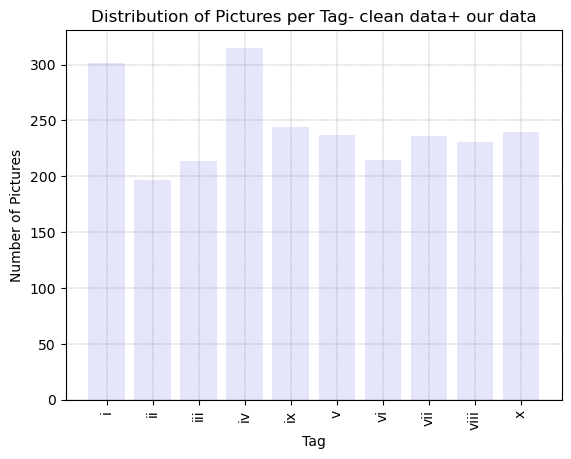

In [19]:
all_data_2 = os.path.join(base_dir, "all_data_2")
clean_train_dataset_2 = load_datasets(all_data_2)
# Get the list of classes/tags in the dataset
class_names = clean_train_dataset_2.classes
# Count the number of pictures under each tag
tag_counts_2 = [0] * len(class_names)
for _, label in clean_train_dataset_2:
    tag_counts_2[label] += 1
# Set the color for the bars
bar_color = '#E6E6FA'
# Plot the histogram
plt.bar(class_names, tag_counts_2, color=bar_color)
plt.xlabel('Tag')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.ylabel('Number of Pictures')
plt.title('Distribution of Pictures per Tag- clean data+ our data')
plt.xticks(rotation=90)
plt.show()

In [20]:
sum(tag_counts_2)

2430

# Data augmentation
In this part we will perform actions in order to increase the number of existing examples

### Data augmentation Part A
The methods used in this section:
1. rotation


In [6]:
j=0

In [7]:
# Define augmentation sequence
seq_1 = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)), # 10 ,-10 rotation
    iaa.Affine(rotate=(-20, 20)), # 20 ,-20 rotation
    iaa.Affine(rotate=(-30, 30)), # 30 ,-30 rotation
], random_order=True)

# Rest of the code remains the same
# Augment images in each class directory
input_directory = "/Users/ofrihefetz/PycharmProjects/LAB2_2/augmentation_data/all_data_2"
output_directory = "/Users/ofrihefetz/PycharmProjects/LAB2_2/augmentation_data/aug_data"
num_augmented = 5  # Number of augmented images to generate per input image

for class_directory in os.listdir(input_directory):
    class_path = os.path.join(input_directory, class_directory)
    output_path = os.path.join(output_directory, class_directory)
    os.makedirs(output_path, exist_ok=True)

    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        augment_image(image_path, output_path, num_augmented, seq_1,j)
        j=j+num_augmented

### Data augmentation Part B
The methods used in this section:
1. random crops
2. Shearing
3. Contrast Adjustment
4. Bluring


In [8]:
seq_2 = iaa.Sequential([
   iaa.Crop(percent=(0, 0.1)),  # random crops
    iaa.Affine(shear=(-20, 20)),  # Shearing
    iaa.Multiply((0.8, 1.2)),
    iaa.BlendAlpha((0.0, 1.0), foreground=iaa.Add(100),background=iaa.Multiply(0.2)),
    iaa.BlendAlphaElementwise( (0.0, 1.0),foreground=iaa.Add(100),background=iaa.Multiply(0.2)),
    ], random_order=True)

for class_directory in os.listdir(input_directory):
    class_path = os.path.join(input_directory, class_directory)
    output_path = os.path.join(output_directory, class_directory)
    os.makedirs(output_path, exist_ok=True)

    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        augment_image(image_path, output_path, num_augmented, seq_2,j)
        j=j+num_augmented

### Data augmentation Part C
The methods used in this section:

1.Contrast Adjustment
2.Noise Addition
3.Brightness Adjustment

In [9]:
seq_3 = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # Noise Addition
    iaa.LinearContrast((0.75, 1.25)),  # Contrast Adjustment
    iaa.AddToBrightness((-30, 30)),  # Brightness Adjustment )
], random_order=True)

for class_directory in os.listdir(input_directory):
    class_path = os.path.join(input_directory, class_directory)
    output_path = os.path.join(output_directory, class_directory)
    os.makedirs(output_path, exist_ok=True)

    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        augment_image(image_path, output_path, num_augmented, seq_3,j)
        j=j+num_augmented

### Data augmentation Part D
The methods used in this section:

1. scalling on the x-axis
2. scaling on the y-axis

In [10]:
seq_4 = iaa.Sequential([
    iaa.ScaleX((0.5, 1.5)),
    iaa.ScaleY((0.5, 1.5)),], random_order=True)

for class_directory in os.listdir(input_directory):
    class_path = os.path.join(input_directory, class_directory)
    output_path = os.path.join(output_directory, class_directory)
    os.makedirs(output_path, exist_ok=True)

    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        augment_image(image_path, output_path, num_augmented, seq_4,j)
        j=j+num_augmented

#### combining all the data + augmnted data

In [11]:
combine_dirs('augmentation_data/all_data_2', 'augmentation_data/aug_data', 'augmentation_data/comb_data_final')

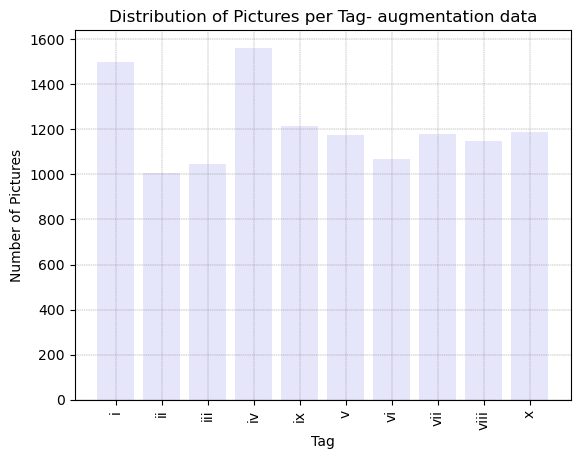

In [19]:
base_dir = os.path.join('/Users/ofrihefetz/PycharmProjects/LAB2_2/augmentation_data')
comb_data_ = os.path.join(base_dir, "comb_data_final")
comb_train_dataset = load_datasets(comb_data_)
# Get the list of classes/tags in the dataset
class_names = clean_train_dataset.classes
# Count the number of pictures under each tag
tag_counts_ = [0] * len(class_names)
for _, label in comb_train_dataset:
    tag_counts_[label] += 1
# Set the color for the bars
bar_color = '#E6E6FA'
# Plot the histogram
plt.bar(class_names, tag_counts_, color=bar_color)
plt.xlabel('Tag')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.ylabel('Number of Pictures')
plt.title('Distribution of Pictures per Tag- augmentation data')
plt.xticks(rotation=90)
plt.show()

In [20]:
sum(tag_counts_)

12083

In [27]:
splitting_data('augmentation_data/comb_data_final', 'augmentation_data/train', 'augmentation_data/val', 0.2)

  0%|          | 0/10 [00:00<?, ?it/s]usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file ... target_directory
usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file ... target_directory
usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file ... target_directory
usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file ... target_directory
usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file ... target_directory
usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file ... target_directory
usage: cp [-R [-H | 